## Comparison between Lofar Analysis implementation on Python and Matlab
##### Author: Pedro Henrique Braga Lisboa
##### Projeto Sonar - Marinha do Brasil
##### Laboratório de Processamento de Sinais - COPPE/UFRJ
##### Laboratório de Tecnologia Sonar - COPPE/UFRJ

#### Summary
----
* [Load Matlab and Python data](#load-data)
* [Raw Data Error Measurement](#raw-error)
* [LOFARgram comparison](#lofargram)
* [Classification Monitoring](#classification)

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.externals import joblib
from Functions.DataHandler import LofarDataset
from Functions.SonarFunctions.read_raw_data import AudioData
from Functions.FunctionsDataVisualization import plotSpectrogram
from Functions.SonarFunctions.lofar_analysis import LofarAnalysis

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rc('legend', **{'fontsize': 15})
plt.rc('font', weight='bold')
sns.set_color_codes()

datapath = os.getenv('OUTPUTDATAPATH')
audiodatapath = os.getenv('INPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')
database = '4classes'

decimation_rate=1
n_pts_fft=1024
n_overlap=0
spectrum_bins_left=400

### Load Matlab and Python generated data  <a name="load-data"></a>
-----------

In [2]:
ad = AudioData(audiodatapath, database)
raw_data,fs = ad.read_raw_data(verbose=1)

#generate python version
la = LofarAnalysis(decimation_rate, n_pts_fft, n_overlap, spectrum_bins_left)
py_data, py_trgt, py_freq = la.from_raw_data(raw_data, fs, database, datapath)

decimation_rate=0
#read matlab version
if not os.path.exists('%s/%s/lofar_data_file_fft_overlap_%i_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (datapath,database,n_pts_fft, n_overlap, decimation_rate,spectrum_bins_left)):
    print('No Files in %s/%s\n'%(data_path,database))
else:
    #Read lofar data
    [mat_data,mat_trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_overlap_%i_%i_decimation_%i_spectrum_left_%i.jbl'%
                                                   (datapath,database,n_pts_fft, n_overlap, decimation_rate,spectrum_bins_left))
decimation_rate=1


Reading Raw data in 4classes database

Reading ClassA
Reading ClassB
Reading ClassC
Reading ClassD


/home/pedrolisboa/.virtualenvs/.virtualenvs/lps/local/lib/python2.7/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/pedrolisboa/.virtualenvs/.virtualenvs/lps/local/lib/python2.7/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


### Sample-wise error between audio files read in python and matlab <a name="raw-error"></a>
------------------

In [3]:
class_labels = {0:'ClassA',1:'ClassB',2:'ClassC',3:'ClassD'}
raw_data_errors = list()
for cls in class_labels.values():
    cls_runs = loadmat(os.path.join(datapath, 
                                    database, 
                                    cls, 
                                    'raw_data_file.mat'))['raw_data']
    cls_runs = cls_runs[0,:]
    for i_run, run_indices in enumerate(raw_data[cls].values()):
        found = False
        for mat_run in cls_runs:
            mat_run = mat_run[:, 0]
            if mat_run.shape == run_indices.shape:
                found=True
                break
        if not found:
            raise ValueError('Class %s runs do not match' % cls)
        run_errors = run_indices - mat_run
        raw_data_errors.append(run_errors)
raw_data_errors = np.concatenate(raw_data_errors)
mean_error = raw_data_errors.mean()
std_error = raw_data_errors.std()

print('Mean Error %i' % mean_error)
print('Std Error %i' % std_error)


Mean Error 0
Std Error 0


##### Conclusion: both representations are equal

### LOFARgram comparison <a name="lofargram"></a>
-------------------

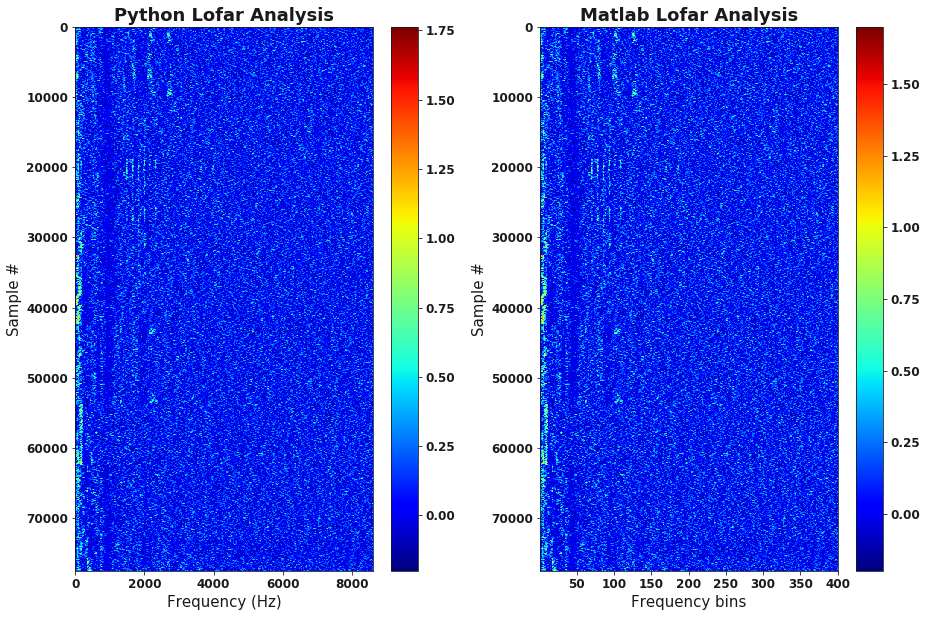

In [4]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(15,10), ncols=2, nrows=1)
plotSpectrogram(py_data, ax=axes[0], colorbar=True, 
                extent=[py_freq[0], py_freq[-1], py_data.shape[0], 1])
plotSpectrogram(mat_data, ax=axes[1], colorbar=True)
fig.subplots_adjust(wspace=0.25)

axes[0].set_title('Python Lofar Analysis')
axes[0].set_ylabel('Sample #')
axes[0].set_xlabel('Frequency (Hz)')
axes[1].set_title('Matlab Lofar Analysis')
axes[1].set_ylabel('Sample #')
axes[1].set_xlabel('Frequency bins');

#### Pixel-wise error between LOFARgrams


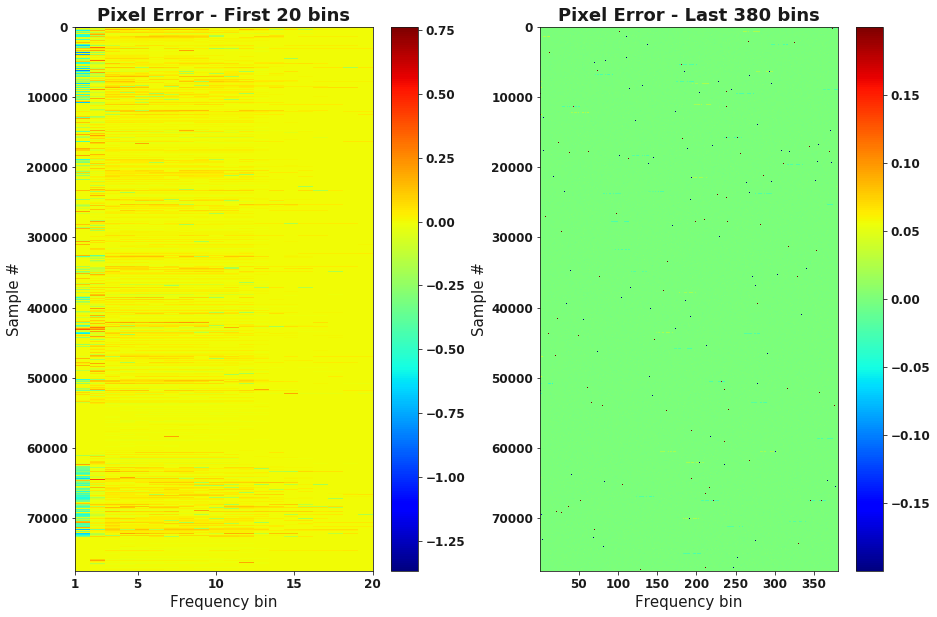

In [5]:
fig, axes = plt.subplots(figsize=(15,10), ncols=2, nrows=1)
slice_pos=20
xs_left = (py_data - mat_data)[:, :slice_pos]
xs_right = (py_data - mat_data)[:, slice_pos:]
plotSpectrogram(xs_left, ax=axes[0], colorbar=True)
plotSpectrogram(xs_right, ax=axes[1], colorbar=True)#, vmin=xs_left.min(), vmax=xs_left.max())

fig.subplots_adjust(wspace=0.25)

axes[0].set_title('Pixel Error - First 20 bins')
xticks = range(0, 21, 5); xticks[0] += 1
axes[0].set_xticks(xticks)
axes[1].set_title('Pixel Error - Last 380 bins');

for ax in axes.flatten():
    ax.set_ylabel('Sample #')
    ax.set_xlabel('Frequency bin');

The high error rate in low frequency bins (first 20) can be explained by inspecting the resulting scipy-generated spectogram before applying the TPSW: the first bins showed a high error rate when subtracted from the matlab version. The TPSW step propagated those differences to adjacent bins.

#### MSE and Average over time

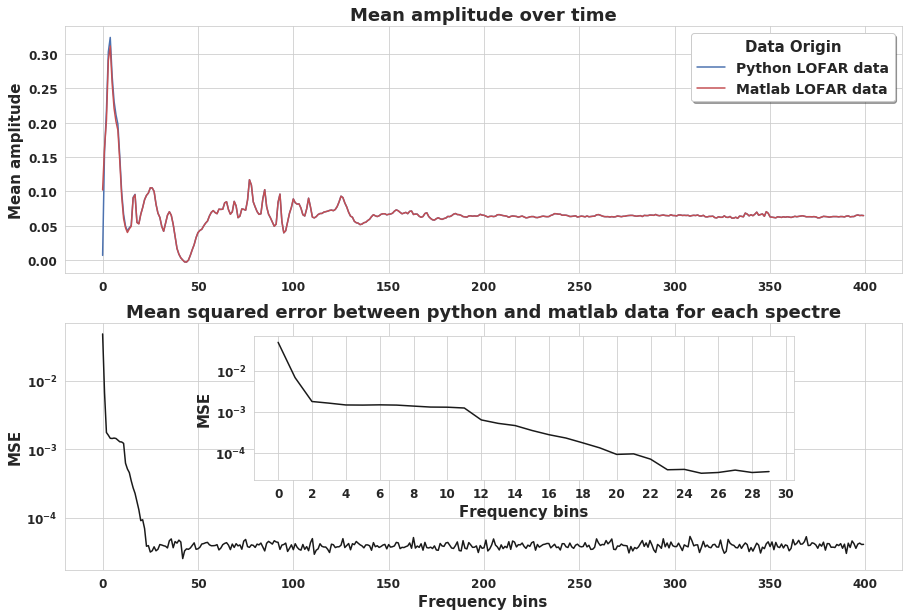

In [6]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=2)

label_fontsize=15
title_fontsize=18

py_time_mean = py_data.mean(axis=0)
mat_time_mean = mat_data.mean(axis=0)

sqr_err = ((py_data - mat_data)**2)
mse = sqr_err.mean(axis=0)

axes[0].plot(range(len(py_time_mean)), py_time_mean, color='b', label='Python LOFAR data')
axes[0].plot(range(len(mat_time_mean)), mat_time_mean, color='r', label='Matlab LOFAR data')
axes[0].set_ylabel('Mean amplitude', fontsize=label_fontsize, weight='bold')
axes[0].set_title('Mean amplitude over time', fontsize=title_fontsize, weight='bold');
legend = axes[0].legend(shadow=True,
                        frameon=True,
                        fancybox=True,
                        title='Data Origin',
                        fontsize=14)
legend.get_title().set_fontsize(15)

axes[1].semilogy(range(len(mse)), mse, color='k')
axes[1].set_ylabel('MSE', fontsize=label_fontsize, weight='bold')
axes[1].set_xlabel('Frequency bins', fontsize=label_fontsize, weight='bold');
axes[1].set_title('Mean squared error between python and matlab data for each spectre', 
                  fontsize=title_fontsize, weight='bold');

zoom_xlim=30
zoom_ax = plt.axes([0.3,0.25,0.5,0.2])
zoom_ax.semilogy(range(len(mse[:zoom_xlim])), mse[:zoom_xlim], color='k')
zoom_ax.set_xticks(range(0, zoom_xlim+1, 2))

zoom_ax.set_ylabel('MSE', fontsize=label_fontsize, weight='bold')
zoom_ax.set_xlabel('Frequency bins', fontsize=label_fontsize, weight='bold');

fig.subplots_adjust(hspace=0.2)


### Classification Monitoring <a name="classification"></a>
------------------------------

#### Model: Neural Network
##### Topology
* Layer 1:
  * Neurons: 10
  * Activation: tanh
* Output Layer
  * Neurons: 4
  * Activation: softmax

#### NN trained on matlab generated data and validated on python generated data

In [7]:
from comparison_model import train_model

mat_scores, mat_cm = train_model(mat_lofar=(mat_data, mat_trgt),
                                 py_lofar=(py_data, py_trgt),
                                 train_on='matlab', results_path=results_path,
                                 n_folds=10, n_iter=1, verbose=0)

py_scores, py_cm = train_model(mat_lofar=(mat_data, mat_trgt),
                               py_lofar=(py_data, py_trgt),
                               train_on='python', results_path=results_path,
                               n_folds=10, n_iter=1, verbose=0)

Using TensorFlow backend.


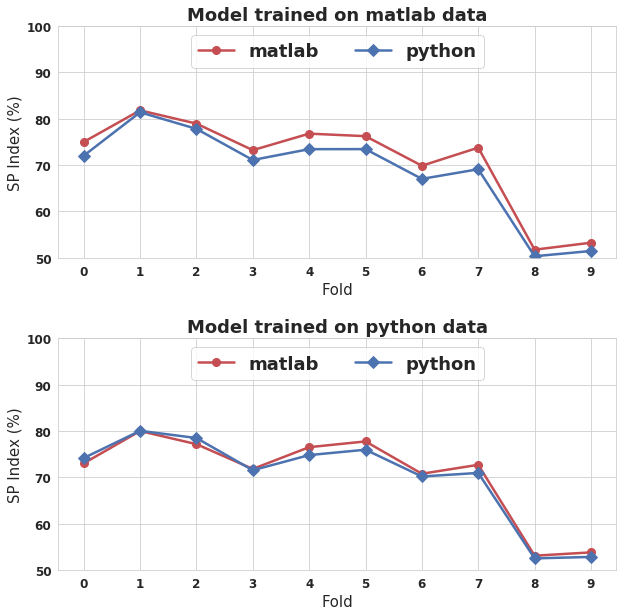

In [8]:
mat_scores = pd.DataFrame(mat_scores)
py_scores = pd.DataFrame(py_scores)
sns.set_style('whitegrid')
sns.set_color_codes()
fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=1)
scores = [mat_scores, py_scores]
for score_table, ax in zip(scores, axes.flatten()):
    ax.plot(score_table['i_fold'], score_table['matlab']*100, 
            marker='o', color='r', linewidth=2.5, markersize=8)
    ax.plot(score_table['i_fold'], score_table['python']*100, 
            marker='D', color='b', linewidth=2.5, markersize=8)
    min_value = min(score_table['matlab'].min(), score_table['python'].min())
    ax.set_ylim(100*np.round(min_value, 1),100)
    ax.set_xticks(range(0,10))
    ax.set_xlabel('Fold')
    ax.set_ylabel('SP Index (%)')
    ax.legend(loc=9, ncol=2, fontsize=18)
axes[0].set_title('Model trained on matlab data')
axes[1].set_title('Model trained on python data')
fig.subplots_adjust(hspace=0.35)

#### NN trained on matlab generated data and validated on python generated data -- **trained and validated only with the last 380 bins**

In [9]:
from comparison_model import train_model
mod_mat_data = mat_data[:, 20:]
mod_py_data = py_data[:, 20:]

mat_scores, mat_cm = train_model(mat_lofar=(mod_mat_data, mat_trgt),
                                 py_lofar=(mod_py_data, py_trgt),
                                 train_on='matlab', results_path=results_path,
                                 n_folds=10, n_iter=1,model_id='trained_on_last_380_bins', verbose=0)

py_scores, py_cm = train_model(mat_lofar=(mod_mat_data, mat_trgt),
                               py_lofar=(mod_py_data, py_trgt),
                               train_on='python', results_path=results_path,
                               n_folds=10, n_iter=1, model_id='trained_on_last_380_bins', verbose=0)

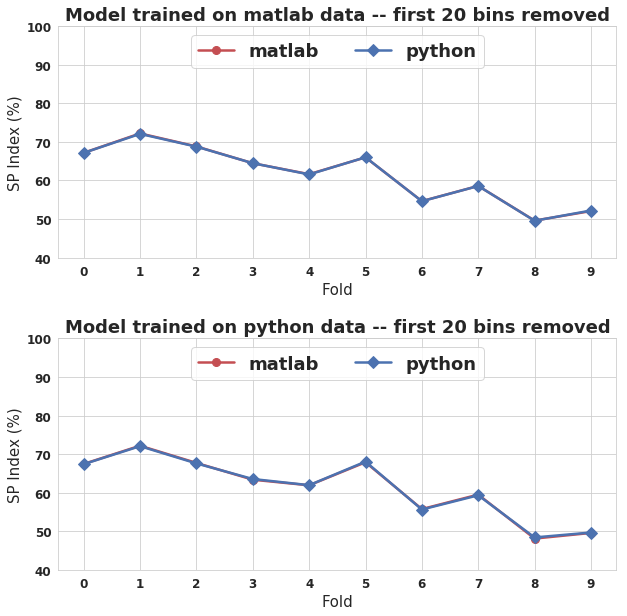

In [12]:
mat_scores = pd.DataFrame(mat_scores)
py_scores = pd.DataFrame(py_scores)
sns.set_style('whitegrid')
sns.set_color_codes()
fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=1)
scores = [mat_scores, py_scores]
for score_table, ax in zip(scores, axes.flatten()):
    ax.plot(score_table['i_fold'], score_table['matlab']*100, 
            marker='o', color='r', linewidth=2.5, markersize=8)
    ax.plot(score_table['i_fold'], score_table['python']*100, 
            marker='D', color='b', linewidth=2.5, markersize=8)
    min_value = min(score_table['matlab'].min(), score_table['python'].min())
    ax.set_ylim(100*np.round(min_value, 1)-10,100)
    ax.set_xticks(range(0,10))
    ax.set_xlabel('Fold')
    ax.set_ylabel('SP Index (%)')
    ax.legend(loc=9, ncol=2, fontsize=18)
axes[0].set_title('Model trained on matlab data -- first 20 bins removed')
axes[1].set_title('Model trained on python data -- first 20 bins removed')
fig.subplots_adjust(hspace=0.35)